In [47]:
import pandas as pd
from scipy import stats
import re

In [23]:
data = {
    "INTERACT": "Element list Homepage Version 1 - Interact, 5-29-2013.csv",
    "CONNECT": "Element list Homepage Version 2 - Connect, 5-29-2013.csv",
    "LEARN": "Element list Homepage Version 3 - Learn, 5-29-2013.csv",
    "HELP": "Element list Homepage Version 4 - Help, 5-29-2013.csv",
    "SERVICES": "Element list Homepage Version 5 - Services, 5-29-2013.csv"
}
df_list = [pd.read_csv("./data/" + file).assign(version = version) for version, file in data.items()]
df = pd.concat(df_list)

In [24]:
df

,Element ID,Tag name,Name,No. clicks,Visible?,Snapshot information,version
0,128,area,Montana State University - Home,1291,False,Homepage Version 1 - Interact • http://www...,INTERACT
1,69,a,FIND,842,True,created 5-29-2013 • 20 days 4 hours 21 min...,INTERACT
2,61,input,s.q,508,True,NaN,INTERACT
3,67,a,lib.montana.edu/find/,166,True,NaN,INTERACT
4,78,a,REQUEST,151,True,NaN,INTERACT
...,...,...,...,...,...,...,...
48,116,div,© MSU About MSU Library Accessibility Contact ...,1,True,NaN,SERVICES
49,130,div,lib.montana.edu/interact/,1,False,NaN,SERVICES
50,131,center,lib.montana.edu/hours/,1,False,NaN,SERVICES
51,132,font,지저귀다,1,False,NaN,SERVICES


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 52
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Element ID            299 non-null    int64 
 1   Tag name              299 non-null    object
 2   Name                  299 non-null    object
 3   No. clicks            299 non-null    int64 
 4   Visible?              299 non-null    bool  
 5   Snapshot information  10 non-null     object
 6   version               299 non-null    object
dtypes: bool(1), int64(2), object(4)
memory usage: 16.6+ KB


In [96]:
dict = {}
for key in data:
    s = df["Snapshot information"].loc[df["version"] == key][1]
    print(key + ": " + s)
    visits = int(re.search("(\d+) visits",s).group(1))
    clicks = df.query(f'Name == "{key}"').get("No. clicks").values[0]
    no_clicks =  visits - clicks
    CTR = clicks / visits
    dict[key] = {"visits" : visits, "clicks" : clicks, "no_clicks" : no_clicks, "CTR" : CTR}

INTERACT: created 5-29-2013   •   20 days 4 hours 21 mins   •   10283 visits, 3714 clicks
CONNECT: created 5-29-2013   •   20 days 7 hours 34 mins   •   2742 visits, 1587 clicks
LEARN: created 5-29-2013   •   20 days 12 hours 21 mins   •   2747 visits, 1652 clicks
HELP: created 5-29-2013   •   20 days 4 hours 59 mins   •   3180 visits, 1717 clicks
SERVICES: created 5-29-2013   •   20 days 4 hours 59 mins   •   2064 visits, 1348 clicks


In [97]:
summary_df = pd.DataFrame.from_dict(dict)
summary_df

,INTERACT,CONNECT,LEARN,HELP,SERVICES
visits,10283.000000,2742.000000,2747.000000,3180.00000,2064.000000
clicks,42.000000,53.000000,21.000000,38.00000,45.000000
no_clicks,10241.000000,2689.000000,2726.000000,3142.00000,2019.000000
CTR,0.004084,0.019329,0.007645,0.01195,0.021802


<Axes: >

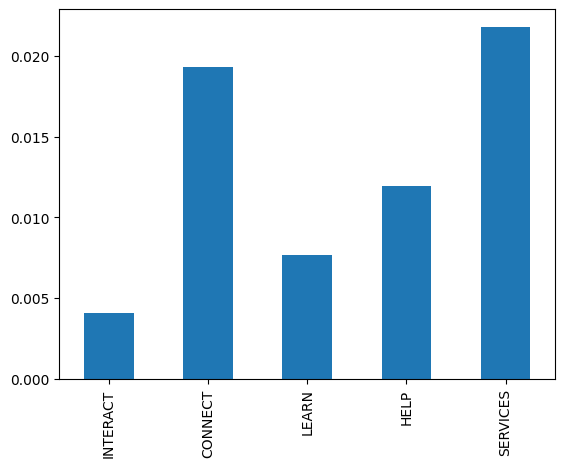

In [104]:
summary_df.loc["CTR"].plot(kind="bar")

In [118]:
chisq, pvalue, df, expected = stats.chi2_contingency(summary_df.loc[["clicks","no_clicks"]])
n=summary_df.loc[["clicks","no_clicks"]].sum().sum()
print(pvalue)
print(f"X2({df}, n = {n}) = {round(chisq,3)}, p < 0.001")

4.8523343010938377e-20
X2(4, n = 21016.0) = 96.743, p < 0.001


In [121]:
def bonferroni(p_values):
  p_adj = p_values * len(p_values)
  p_adj[p_adj > 1] = 1
  return p_adj

post_hoc_df = pd.DataFrame(index = range(0,4), columns = ["pair","X2","n","df","p","p_adj"])
for i in range(0,4):
  pair_cont_df = summary_df.loc[["clicks","no_clicks"]].iloc[:,[i,4]]
  post_hoc_df.loc[i,["pair"]] = summary_df.loc[["clicks","no_clicks"]].columns[i] + " vs. SERVICES"
  post_hoc_df.loc[i,["n"]] = pair_cont_df.sum().sum()
  post_hoc_df.loc[i,["X2","p","df"]] = stats.chi2_contingency(pair_cont_df)[0:3]

post_hoc_df["p_adj"] = bonferroni(post_hoc_df["p"])
post_hoc_df

,pair,X2,n,df,p,p_adj
0,INTERACT vs. SERVICES,74.615427,12347.0,1,0.0,0.0
1,CONNECT vs. SERVICES,0.247449,4806.0,1,0.618877,1
2,LEARN vs. SERVICES,16.427709,4811.0,1,0.000051,0.000202
3,HELP vs. SERVICES,7.180282,5244.0,1,0.007371,0.029484
